Saved: joint_er_100/train_loss_vs_dev_f1.png


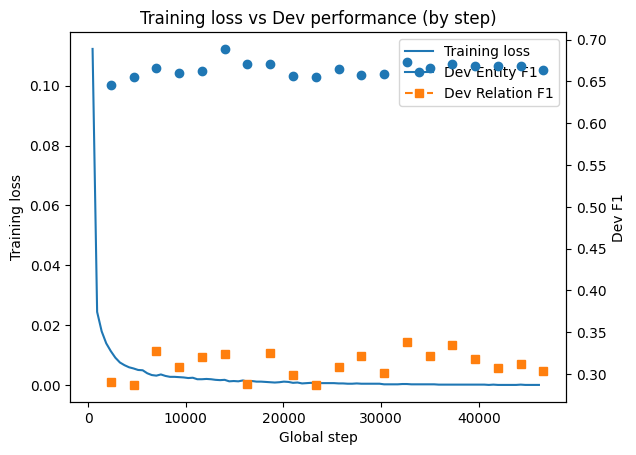

In [14]:
# plot_train_vs_dev.py
import json, re, glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

folder = "../experiments/scierc_joint_er-t5-base-ep100-len512-b4-train/"
# --- inputs
TRAINER_STATE = Path("./joint_er_100/trainer_state.json")               # adjust if needed
DEV_PATTERN   = folder + "results*-dev-checkpoint-*.json"      # glob for all dev checkpoint files
OUT_PNG       = "joint_er_100/train_loss_vs_dev_f1.png"

# --- load training log (HF Trainer state)
with TRAINER_STATE.open("r", encoding="utf-8") as f:
    ts = json.load(f)
train_df = pd.DataFrame(ts.get("log_history", []))
if "step" not in train_df.columns and len(train_df) > 0:
    train_df["step"] = np.arange(1, len(train_df)+1)
train_df = train_df.dropna(subset=["step", "loss"]).sort_values("step")

# --- load dev metrics across checkpoints
rows = []
for fp in glob.glob(DEV_PATTERN):
    p = Path(fp)
    m = re.search(r"checkpoint-(\d+)\.json$", p.name)
    step = int(m.group(1)) if m else None
    with p.open("r", encoding="utf-8") as f:
        data = json.load(f)

    # helper: accept either scalar or list [val, 0.0] and ignore trailing zeros
    def val(x):
        if isinstance(x, list):
            for v in x:
                if isinstance(v, (int, float)) and v != 0:
                    return float(v)
            return None
        return float(x) if isinstance(x, (int, float)) else None

    rows.append({
        "step": step,
        "entity_f1": val(data.get("entity_f1")),
        "relation_f1": val(data.get("relation_f1")),
        "entity_f1_no_type": val(data.get("entity_f1_no_type")),
        "path": str(p),
    })

dev_df = pd.DataFrame(rows)
if not dev_df.empty:
    dev_df = dev_df.dropna(subset=["step"]).sort_values("step")

# --- merge on step (outer join so you still see loss curve even if dev is sparse)
view = train_df[["step","loss"]].merge(
    dev_df[["step","entity_f1","relation_f1","entity_f1_no_type"]] if not dev_df.empty else
    pd.DataFrame(columns=["step","entity_f1","relation_f1","entity_f1_no_type"]),
    on="step", how="outer"
).sort_values("step")

# --- plot (single figure, twin y-axes, no seaborn, no manual colors)
fig, ax1 = plt.subplots()
l1, = ax1.plot(view["step"], view["loss"], label="Training loss")
ax1.set_xlabel("Global step")
ax1.set_ylabel("Training loss")

ax2 = ax1.twinx()
handles = [l1]
labels  = [l1.get_label()]

if "entity_f1" in view and view["entity_f1"].notna().any():
    l2, = ax2.plot(view["step"], view["entity_f1"], marker="o", linestyle="-", label="Dev Entity F1")
    handles.append(l2); labels.append(l2.get_label())

if "relation_f1" in view and view["relation_f1"].notna().any():
    l3, = ax2.plot(view["step"], view["relation_f1"], marker="s", linestyle="--", label="Dev Relation F1")
    handles.append(l3); labels.append(l3.get_label())

# optionally include span-only F1 (uncomment)
# if "entity_f1_no_type" in view and view["entity_f1_no_type"].notna().any():
#     l4, = ax2.plot(view["step"], view["entity_f1_no_type"], marker="^", linestyle=":", label="Dev Entity F1 (no type)")
#     handles.append(l4); labels.append(l4.get_label())

ax2.set_ylabel("Dev F1")
ax1.legend(handles, labels, loc="best")
ax1.set_title("Training loss vs Dev performance (by step)")

fig.savefig(OUT_PNG, dpi=150, bbox_inches="tight")
print(f"Saved: {OUT_PNG}")

Saved: entity_pr_vs_step.png relation_pr_vs_step.png


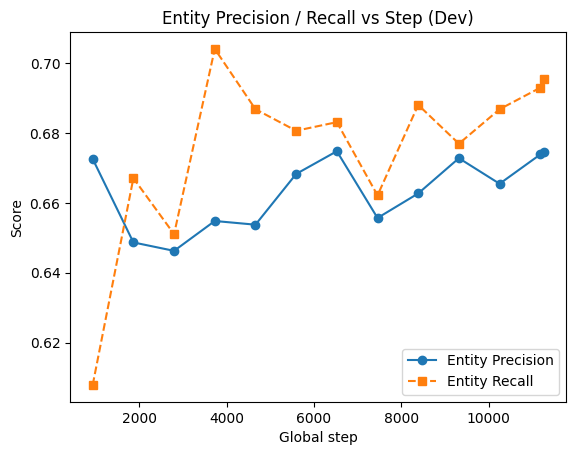

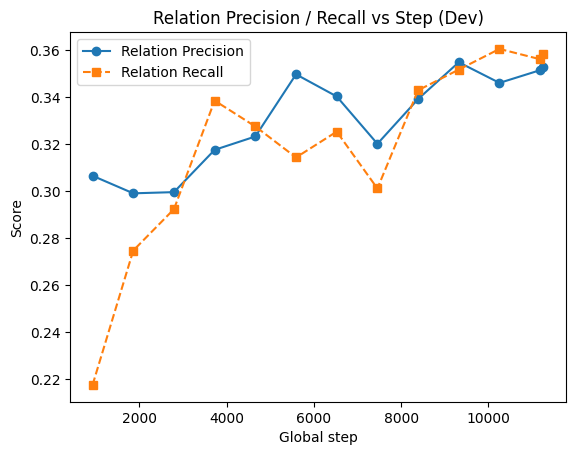

In [20]:
# plot_precision_recall_vs_step.py
import json, re, glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

folder = "../experiments/scierc_all-t5-base-ep20-len512-b4-train-chunk192-overlap48/"


DEV_PATTERN = folder+"results*-scierc_joint_er-dev-checkpoint-*.json"  # adjust path if needed
OUT1 = "entity_pr_vs_step.png"
OUT2 = "relation_pr_vs_step.png"

def first_numeric(x):
    # Handles either scalars or lists like [value, 0.0]
    if isinstance(x, list):
        for v in x:
            if isinstance(v, (int, float)):
                return float(v)
        return None
    return float(x) if isinstance(x, (int, float)) else None

rows = []
for fp in glob.glob(DEV_PATTERN):
    p = Path(fp)
    m = re.search(r"checkpoint-(\d+)\.json$", p.name)
    step = int(m.group(1)) if m else None
    with p.open("r", encoding="utf-8") as f:
        data = json.load(f)
    rows.append({
        "step": step,
        "entity_precision": first_numeric(data.get("entity_precision")),
        "entity_recall": first_numeric(data.get("entity_recall")),
        "relation_precision": first_numeric(data.get("relation_precision")),
        "relation_recall": first_numeric(data.get("relation_recall")),
    })

df = pd.DataFrame(rows).dropna(subset=["step"]).sort_values("step")

# --- Plot 1: Entity P/R vs step
plt.figure()
plt.plot(df["step"], df["entity_precision"], marker="o", linestyle="-", label="Entity Precision")
plt.plot(df["step"], df["entity_recall"],    marker="s", linestyle="--", label="Entity Recall")
plt.xlabel("Global step")
plt.ylabel("Score")
plt.title("Entity Precision / Recall vs Step (Dev)")
plt.legend()
plt.savefig(OUT1, dpi=150, bbox_inches="tight")

# --- Plot 2: Relation P/R vs step
plt.figure()
plt.plot(df["step"], df["relation_precision"], marker="o", linestyle="-", label="Relation Precision")
plt.plot(df["step"], df["relation_recall"],    marker="s", linestyle="--", label="Relation Recall")
plt.xlabel("Global step")
plt.ylabel("Score")
plt.title("Relation Precision / Recall vs Step (Dev)")
plt.legend()
plt.savefig(OUT2, dpi=150, bbox_inches="tight")

print("Saved:", OUT1, OUT2)
